# Word2Vec-以 gensim 訓練中文詞向量
## 參考及引用資料來源

- [1] [zake7749-使用 gensim 訓練中文詞向量](http://zake7749.github.io/2016/08/28/word2vec-with-gensim/)
* [2] [gensim/corpora/wikicorpus](https://radimrehurek.com/gensim/corpora/wikicorpus.html)
- [Word2Vec的簡易教學與參數調整指南](https://www.kaggle.com/jerrykuo7727/word2vec)
* [zhconv](https://pypi.org/project/zhconv/)
* [jieba](https://pypi.org/project/jieba/)





確認相關 Packages

In [14]:
import os
import requests
import zhconv
from gensim.corpora import WikiCorpus
from datetime import datetime as dt
from typing import List

# Check if the dictionary file exists, if not, download it
dict_file = 'dict.txt.big'

if not os.path.isfile(dict_file):
    url = 'https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big'
    response = requests.get(url)
    with open(dict_file, 'wb') as f:
        f.write(response.content)

# Load jieba dictionary
import jieba
jieba.set_dictionary(dict_file)

# Verify versions
import gensim
print("gensim", gensim.__version__)
print("jieba", jieba.__version__)


gensim 4.3.3
jieba 0.42.1


# 準備中文訓練文本



## 訓練文本來源: [維基百科資料庫](https://zh.wikipedia.org/wiki/Wikipedia:%E6%95%B0%E6%8D%AE%E5%BA%93%E4%B8%8B%E8%BD%BD)
> 要訓練詞向量，第一步當然是取得資料集。由於 word2vec 是基於非監督式學習，**訓練集一定一定要越大越好，語料涵蓋的越全面，訓練出來的結果也會越漂亮**。[[1]](http://zake7749.github.io/2016/08/28/word2vec-with-gensim/)

- [zhwiki-20210101-pages-articles.xml.bz2](https://dumps.wikimedia.org/zhwiki/20210101/zhwiki-20210101-pages-articles.xml.bz2) (1.9 GB)

> ```
wget "https://dumps.wikimedia.org/zhwiki/20210101/zhwiki-20210101-pages-articles.xml.bz2"
```



目前已經使用另一份 Notebook ([維基百科中文語料庫 zhWiki_20210101](https://www.kaggle.com/bbqlp33/zhwiki-20210101)) 下載好中文維基百科語料，並可以直接引用

In [15]:
ZhWiki = r"C:\Users\USER\Downloads\zh_classicalwiki-20170720-pages-articles-multistream.xml.bz2"

!du -sh $ZhWiki
!md5sum $ZhWiki
!file $ZhWiki

'du' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'md5sum' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'file' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


# 中文文本前處理

在正式訓練 `Word2Vec` 之前，其實涉及了文本的前處理，本篇的處理包括如下三點 (而實務上對應的不同使用情境，可能會有不同的前處理流程):

* 簡轉繁: [zhconv](https://pypi.org/project/zhconv/)
* 中文斷詞: [jieba](https://pypi.org/project/jieba/)
* 停用詞

## 簡繁轉換

wiki 文本其實摻雜了簡體與繁體中文，比如「数学」與「數學」，這會被 word2vec 當成兩個不同的詞。[[1]](http://zake7749.github.io/2016/08/28/word2vec-with-gensim/)
<br>
所以我們在斷詞前，需要加上簡繁轉換的手續

---

以下範例使用了較輕量的 Package [zhconv](https://pypi.org/project/zhconv/)，
<br>
若需要更高的精準度，則可以參考  [OpenCC](https://github.com/BYVoid/OpenCC)

In [16]:
zhconv.convert("这原本是一段简体中文", "zh-tw")

'這原本是一段簡體中文'

## 中文斷詞
使用 [jieba](https://pypi.org/project/jieba/) `jieba.cut` 來進行中文斷詞，
<br>
並簡單介紹 jieba 的兩種分詞模式:
* `cut_all=False` **精確模式**，試圖將句子最精確地切開，適合文本分析；
* `cut_all=True` **全模式**，把句子中所有的可以成詞的詞語都掃描出來, 速度非常快，但是不能解決歧義；

而本篇文本訓練採用**精確模式** `cut_all=False`

In [17]:
seg_list = jieba.cut("我来到北京清华大学", cut_all=True)
print("Full Mode: " + "/ ".join(seg_list))  # 全模式

seg_list = jieba.cut("我来到北京清华大学", cut_all=False)
print("Default Mode: " + "/ ".join(seg_list))  # 精確模式

Building prefix dict from c:\Users\USER\Desktop\mypython\nlp\Search\dict.txt.big ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.u8ea9a500420fbeea80a0811675cd0521.cache
Loading model cost 0.967 seconds.
Prefix dict has been built successfully.


Full Mode: 我/ 来到/ 北京/ 清华/ 清华大学/ 华大/ 大学
Default Mode: 我/ 来到/ 北京/ 清华大学


In [18]:
print(list(jieba.cut("中英夾雜的example，Word2Vec應該很interesting吧?")))

['中', '英', '夾雜', '的', 'example', '，', 'Word2Vec', '應該', '很', 'interesting', '吧', '?']


## 引入停用詞表

停用詞就是像英文中的 **the,a,this**，中文的**你我他**，與其他詞相比顯得不怎麼重要，對文章主題也無關緊要的，
<br>
是否要使用停用詞表，其實還是要看你的應用，也有可能保留這些停用詞更能達到你的目標。[[1]](http://zake7749.github.io/2016/08/28/word2vec-with-gensim/)
<br>


* [Is it compulsory to remove stop words with word2vec?](https://www.quora.com/Is-it-compulsory-to-remove-stop-words-with-word2vec)
* [The Effect of Stopword Filtering prior to Word Embedding Training](https://stats.stackexchange.com/questions/201372/the-effect-of-stopword-filtering-prior-to-word-embedding-training)

---

以下範例還是示範引入停用詞表，而停用詞表網路上有各種各樣的資源
<br>
剛好 `kaggle`，環境預設有裝 [spacy](https://pypi.org/project/spacy/)，
<br>
就順道引用 `spacy` 提供的停用詞表吧 (實務上stopwords 應為另外準備好且檢視過的靜態文檔)

In [19]:
import spacy

# 下載語言模組
spacy.cli.download("zh_core_web_sm")  # 下載 spacy 中文模組
spacy.cli.download("en_core_web_sm")  # 下載 spacy 英文模組

nlp_zh = spacy.load("zh_core_web_sm") # 載入 spacy 中文模組
nlp_en = spacy.load("en_core_web_sm") # 載入 spacy 英文模組

# 印出前20個停用詞
print('--\n')
print(f"中文停用詞 Total={len(nlp_zh.Defaults.stop_words)}: {list(nlp_zh.Defaults.stop_words)[:20]} ...")
print("--")
print(f"英文停用詞 Total={len(nlp_en.Defaults.stop_words)}: {list(nlp_en.Defaults.stop_words)[:20]} ...")

✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
--

中文停用詞 Total=1891: ['＝｛', '待到', '于', '依据', '除开', '并且', '她', '彻底', '一转眼', '二话不说', '忽然', '换句话说', '除了', '当中', '好象', '大事', '接著', '这个', '故而', '本'] ...
--
英文停用詞 Total=326: ['otherwise', 'again', 'hundred', 'beside', 'see', 'between', 'around', 'one', 'until', 'or', 'therein', 'but', '‘m', 'two', 'enough', 'eight', 'own', 'those', 'twenty', 'do'] ...


In [20]:
STOPWORDS =  nlp_zh.Defaults.stop_words | \
             nlp_en.Defaults.stop_words | \
             set(["\n", "\r\n", "\t", " ", ""])
print(len(STOPWORDS))

# 將簡體停用詞轉成繁體，擴充停用詞表
for word in STOPWORDS.copy():
    STOPWORDS.add(zhconv.convert(word, "zh-tw"))
    
print(len(STOPWORDS))

2222
3005


# 讀取 wiki 語料庫，並且進行前處理和斷詞

維基百科 (`wiki.xml.bz2`)下載好後，先別急著解壓縮，因為這是一份 xml 文件，裏頭佈滿了各式各樣的標籤，我們得先想辦法送走這群不速之客，不過也別太擔心，`gensim` 早已看穿了一切，藉由調用 [wikiCorpus](https://radimrehurek.com/gensim/corpora/wikicorpus.html)，我們能很輕鬆的只取出文章的標題和內容。[[1]](http://zake7749.github.io/2016/08/28/word2vec-with-gensim/)

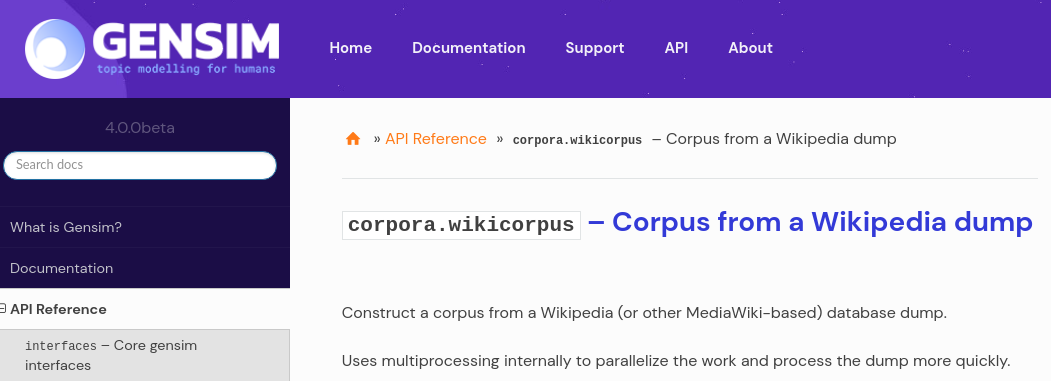

 [[2]](https://radimrehurek.com/gensim/corpora/wikicorpus.html)

---

Supported dump formats:

- `<LANG>wiki-<YYYYMMDD>-pages-articles.xml.bz2`

- `<LANG>wiki-latest-pages-articles.xml.bz2`

The documents are extracted on-the-fly, so that the whole (massive) dump can stay compressed on disk.


In [21]:
def preprocess_and_tokenize(
    text: str, token_min_len: int=1, token_max_len: int=15, lower: bool=True) -> List[str]:
    if lower:
        text  = text.lower()
    text = zhconv.convert(text, "zh-tw")
    return [
        token for token in jieba.cut(text, cut_all=False)
        if token_min_len <= len(token) <= token_max_len and \
            token not in STOPWORDS
    ]


In [22]:
print(preprocess_and_tokenize("歐幾里得，西元前三世紀的古希臘數學家，現在被認為是幾何之父，此畫為拉斐爾"))
print(preprocess_and_tokenize("我来到北京清华大学"))
print(preprocess_and_tokenize("中英夾雜的example，Word2Vec應該很interesting吧?"))

['歐幾', '裡得', '西元前', '世紀', '古希臘', '數學家', '幾何', '父', '此畫', '拉斐爾']
['來到', '北京', '清華大學']
['中', '英', '夾雜', 'example', 'word2vec', 'interesting']


In [ ]:
%%time

print(f"Parsing {ZhWiki}...")
wiki_corpus = WikiCorpus(ZhWiki, tokenizer_func=preprocess_and_tokenize, token_min_len=1)

Parsing C:\Users\USER\Downloads\zh_classicalwiki-20170720-pages-articles-multistream.xml.bz2...


初始化`WikiCorpus`後，能藉由`get_texts()`可迭代每一篇文章，它所回傳的是一個`tokens list`，我以空白符將這些 `tokens` 串接起來，統一輸出到同一份文字檔裡。這邊要注意一件事，`get_texts()`受 `article_min_tokens` 參數的限制，只會回傳內容長度大於 **50** (default) 的文章。

- **article_min_tokens** *(int, optional)* – Minimum tokens in article. Article will be ignored if number of tokens is less.

秀出前 3 偏文章的前10 個 token

In [ ]:
g = wiki_corpus.get_texts()
print(next(g)[:10])
print(next(g)[:10])
print(next(g)[:10])


# print(jieba.lcut("".join(next(g))[:50]))
# print(jieba.lcut("".join(next(g))[:50]))


NameError: name 'wiki_corpus' is not defined

## 將處理完的語料集存下來，供後續使用

In [ ]:
WIKI_SEG_TXT = "wiki_seg.txt"

generator = wiki_corpus.get_texts()

with open(WIKI_SEG_TXT, "w", encoding='utf-8') as output:
    for texts_num, tokens in enumerate(generator):
        output.write(" ".join(tokens) + "\n")

        if (texts_num + 1) % 100000 == 0:
            print(f"[{str(dt.now()):.19}] 已寫入 {texts_num} 篇斷詞文章")

[2021-01-06 21:58:03] 已寫入 99999 篇斷詞文章
[2021-01-06 22:17:09] 已寫入 199999 篇斷詞文章
[2021-01-06 22:34:29] 已寫入 299999 篇斷詞文章
[2021-01-06 22:54:55] 已寫入 399999 篇斷詞文章
[2021-01-06 23:12:20] 已寫入 499999 篇斷詞文章
[2021-01-06 23:28:14] 已寫入 599999 篇斷詞文章


# 訓練 Word2Vec

In [ ]:
%%time

from gensim.models import word2vec
import multiprocessing

max_cpu_counts = multiprocessing.cpu_count()
word_dim_size = 300  #  設定 word vector 維度
print(f"Use {max_cpu_counts} workers to train Word2Vec (dim={word_dim_size})")


# 讀取訓練語句
sentences = word2vec.LineSentence(WIKI_SEG_TXT)

# 訓練模型
model = word2vec.Word2Vec(sentences, size=word_dim_size, workers=max_cpu_counts)

# 儲存模型
output_model = f"word2vec.zh.{word_dim_size}.model"
model.save(output_model)

Use 4 workers to train Word2Vec (dim=300)
CPU times: user 3h 8min 9s, sys: 1min 25s, total: 3h 9min 34s
Wall time: 1h 4min 34s


儲存的模型總共會產生三份檔案

In [ ]:
! ls word2vec.zh*

word2vec.zh.300.model
word2vec.zh.300.model.trainables.syn1neg.npy
word2vec.zh.300.model.wv.vectors.npy


In [ ]:
!du -sh word2vec.zh*

71M	word2vec.zh.300.model
1.3G	word2vec.zh.300.model.trainables.syn1neg.npy
1.3G	word2vec.zh.300.model.wv.vectors.npy


 # 查看模型以及詞向量實驗

模型其實就是巨大的 Embedding Matrix


In [ ]:
print(model.wv.vectors.shape)
model.wv.vectors

(1138562, 300)


array([[-1.9005029e+00, -2.8552267e-01, -1.6861261e+00, ...,
        -2.3989561e+00,  7.9282230e-01, -1.7689761e+00],
       [-8.9374363e-01,  2.7187495e+00, -2.8586307e+00, ...,
         7.6278639e-01, -1.2364342e+00,  4.6035990e-01],
       [-1.3627478e+00,  9.0678096e-01, -2.4168897e+00, ...,
         1.9464742e-01,  2.3467582e-01, -4.3651393e-01],
       ...,
       [ 1.1225304e-01, -2.3689542e-02,  5.3460799e-02, ...,
         1.8911289e-02,  6.1728880e-02, -2.9928887e-02],
       [ 1.0599125e-01,  1.4494479e-03, -7.2507304e-03, ...,
         3.7081163e-02,  1.5778864e-02, -1.6071750e-02],
       [-5.2874412e-02, -6.3391119e-02, -1.4798551e-02, ...,
        -7.8865103e-02,  3.2674141e-02, -2.9911553e-02]], dtype=float32)

收錄的詞彙

In [ ]:
print(f"總共收錄了 {len(model.wv.vocab)} 個詞彙")

print("印出 20 個收錄詞彙:")
print(list(model.wv.vocab.keys())[:10])

總共收錄了 1138562 個詞彙
印出 20 個收錄詞彙:
['歐幾里得', '西元前', '世紀', '古希臘', '數學家', '認為', '幾何', '父', '此畫', '為']


詞彙的向量

In [ ]:
vec = model.wv['數學家']
print(vec.shape)
vec 

(300,)


array([-0.15254694, -1.7895197 ,  2.8389933 ,  0.30419526,  0.94147015,
       -0.924163  ,  0.05298484, -0.13174261, -1.4274364 , -0.85435706,
        1.8479271 , -1.0273514 ,  0.05875092,  1.6739838 ,  2.3618689 ,
        2.0175905 , -1.5817889 , -0.8472086 ,  1.1092311 , -0.24629189,
        0.49799377,  0.36100635, -0.281036  , -0.5806378 , -1.8780046 ,
        0.2837012 , -0.11682022, -0.22787744,  0.11489099, -0.14591609,
       -0.20482585, -1.1253157 , -0.01348399, -1.0098934 ,  3.2184417 ,
       -0.7147375 , -0.7956163 ,  1.9969889 ,  0.14035068,  3.6188982 ,
        1.7953273 , -1.4445941 ,  0.37768763, -0.77543026, -0.69721234,
        0.8814372 , -0.46651804,  1.7810897 ,  1.9077462 ,  0.33889568,
        2.4865808 ,  0.03023988, -1.7290001 ,  0.52984065,  1.971243  ,
        1.042733  , -2.2933383 , -0.15407254,  1.0061789 ,  0.36432067,
       -0.12965468,  0.22315088, -0.6530562 ,  0.5096923 ,  1.6476531 ,
       -2.1283326 , -0.41265398,  3.710713  , -2.182122  , -1.22

沒見過的詞彙

In [ ]:
word = "這肯定沒見過 "

# 若強行取值會報錯
try:
    vec = model.wv[word]
except KeyError as e:
    print(e)

"word '這肯定沒見過 ' not in vocabulary"


## 查看前 10 名相似詞

`model.wv.most_similar` 的 `topn` 預設為 10

In [ ]:
model.wv.most_similar("飲料", topn=10)

[('飲品', 0.7986035346984863),
 ('果汁', 0.6965157389640808),
 ('含酒精', 0.6784194707870483),
 ('提神', 0.6489840149879456),
 ('酒精類', 0.6488814353942871),
 ('罐裝', 0.6478314995765686),
 ('軟飲料', 0.6374701261520386),
 ('啤酒', 0.6282455921173096),
 ('酒類', 0.6256542801856995),
 ('優格', 0.6210787892341614)]

In [ ]:
model.wv.most_similar("car")

[('truck', 0.6967549324035645),
 ('motor', 0.6519397497177124),
 ('motorcycle', 0.6470927596092224),
 ('seat', 0.6359925866127014),
 ('vehicle', 0.6339040994644165),
 ('chevrolet', 0.6203585267066956),
 ('wagon', 0.6203234195709229),
 ('volkswagen', 0.6184985637664795),
 ('cab', 0.6164493560791016),
 ('carriage', 0.6120896339416504)]

In [ ]:
model.wv.most_similar("facebook")

[('臉書', 0.8205897212028503),
 ('專頁', 0.7610922455787659),
 ('面書', 0.7400078773498535),
 ('instagram', 0.7310690879821777),
 ('貼文', 0.7073413729667664),
 ('推特', 0.6892963647842407),
 ('粉絲團', 0.6821428537368774),
 ('twitter', 0.6560337543487549),
 ('網誌', 0.6300784349441528),
 ('youtube', 0.626787543296814)]

In [ ]:
model.wv.most_similar("詐欺")

[('欺詐', 0.7422803640365601),
 ('詐騙', 0.6307169198989868),
 ('竊盜', 0.5821384191513062),
 ('慣犯', 0.5790081024169922),
 ('詐欺罪', 0.5757179260253906),
 ('信用調查', 0.548001766204834),
 ('詐術', 0.5453300476074219),
 ('逃稅', 0.5242756605148315),
 ('逃漏稅', 0.5208016633987427),
 ('賭博', 0.5206777453422546)]

In [ ]:
model.wv.most_similar("合約")

[('合同', 0.7740179896354675),
 ('簽約', 0.6996151208877563),
 ('續約', 0.6664248704910278),
 ('租約', 0.616113007068634),
 ('簽下', 0.615209698677063),
 ('續簽', 0.6073216199874878),
 ('買斷', 0.5997638702392578),
 ('新東家', 0.5763907432556152),
 ('選擇權', 0.5660616159439087),
 ('勞動合同', 0.5596709251403809)]

## 計算 Cosine 相似度

In [ ]:
model.wv.similarity("連結", "鍵接")

0.709352

In [ ]:
model.wv.similarity("連結", "陰天")

-0.023800302

 # 讀取模型

In [ ]:
print(f"Loading {output_model}...")
new_model = word2vec.Word2Vec.load(output_model)

Loading word2vec.zh.300.model...


In [ ]:
model.wv.similarity("連結", "陰天") == new_model.wv.similarity("連結", "陰天")

True